<a href="https://colab.research.google.com/github/Biruk-gebru/RNNTraining-/blob/main/RNNTask3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv


--2025-06-25 17:43:34--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2025-06-25 17:43:35 (4.59 MB/s) - ‘daily-min-temperatures.csv’ saved [67921/67921]



In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("daily-min-temperatures.csv", parse_dates=["Date"])
df.head()


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


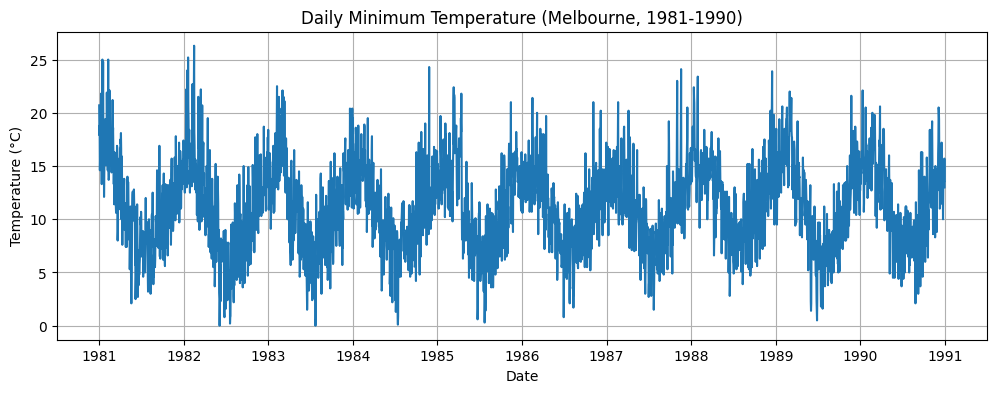

In [3]:
# Plot full time-series
plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["Temp"])
plt.title("Daily Minimum Temperature (Melbourne, 1981-1990)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# Normalize temperature
scaler = MinMaxScaler()
temps = scaler.fit_transform(df["Temp"].values.reshape(-1, 1)).flatten()

# Create sliding window dataset
def create_sequences(data, window_size=30):
    xs, ys = [], []
    for i in range(len(data) - window_size):
        x = data[i:i+window_size]
        y = data[i+window_size]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

window_size = 30
X, y = create_sequences(temps, window_size=window_size)

# Train/test split (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [6]:
import torch

class TempDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TempDataset(X_train, y_train)
test_ds = TempDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


In [7]:
import torch.nn as nn

class TempLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(TempLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last output only
        out = self.fc(out)
        return out.squeeze()


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TempLSTM().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
def train(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")
train(model, train_loader, epochs=15)


Epoch 1, Loss: 0.0445
Epoch 2, Loss: 0.0175
Epoch 3, Loss: 0.0129
Epoch 4, Loss: 0.0117
Epoch 5, Loss: 0.0118
Epoch 6, Loss: 0.0119
Epoch 7, Loss: 0.0115
Epoch 8, Loss: 0.0114
Epoch 9, Loss: 0.0112
Epoch 10, Loss: 0.0112
Epoch 11, Loss: 0.0110
Epoch 12, Loss: 0.0110
Epoch 13, Loss: 0.0110
Epoch 14, Loss: 0.0105
Epoch 15, Loss: 0.0105


✅ MSE:  5.6062
✅ MAE:  1.8338
✅ R²:   0.6664
✅ MSLE: 0.0584
✅ MedAE:1.5044
✅ EVS:  0.6665


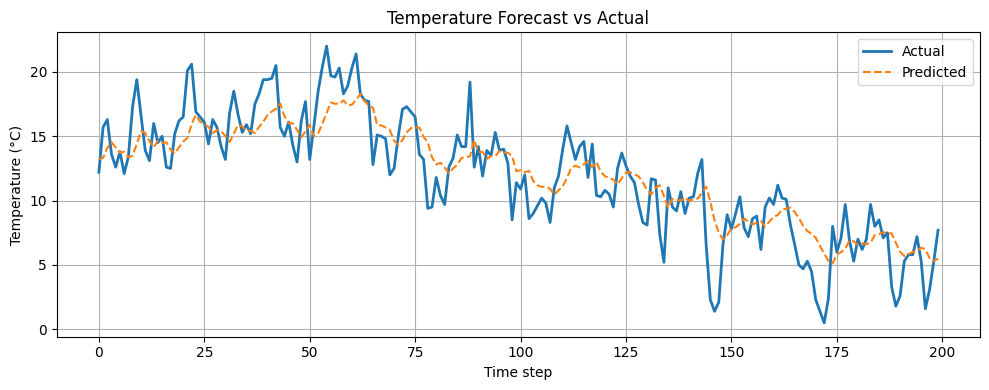

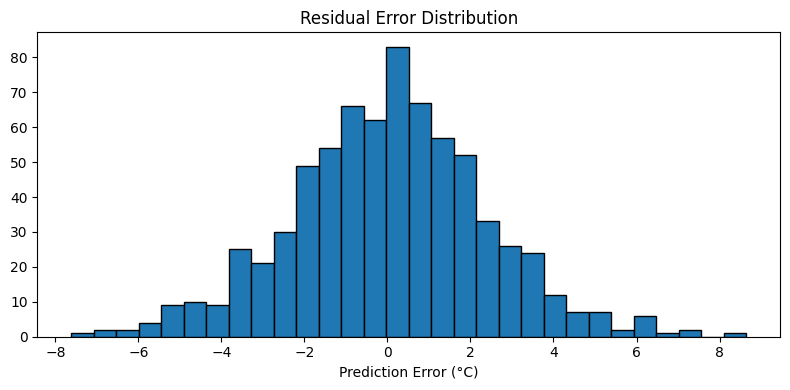

In [11]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    mean_squared_log_error, median_absolute_error, explained_variance_score
)
import matplotlib.pyplot as plt
import os

# Create output directory
os.makedirs("results", exist_ok=True)

def inverse_transform(values):
    return scaler.inverse_transform(np.array(values).reshape(-1, 1)).flatten()

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_truths = [], []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu()
            all_preds.extend(outputs.tolist())
            all_truths.extend(y_batch.tolist())

    # Inverse transform to real °C
    preds_real = inverse_transform(all_preds)
    truths_real = inverse_transform(all_truths)

    # --- Metrics ---
    mse = mean_squared_error(truths_real, preds_real)
    mae = mean_absolute_error(truths_real, preds_real)
    r2 = r2_score(truths_real, preds_real)
    mdae = median_absolute_error(truths_real, preds_real)
    msle = mean_squared_log_error(truths_real, preds_real)
    evs = explained_variance_score(truths_real, preds_real)

    print(f"✅ MSE:  {mse:.4f}")
    print(f"✅ MAE:  {mae:.4f}")
    print(f"✅ R²:   {r2:.4f}")
    print(f"✅ MSLE: {msle:.4f}")
    print(f"✅ MedAE:{mdae:.4f}")
    print(f"✅ EVS:  {evs:.4f}")

    # --- Plot prediction vs actual ---
    plt.figure(figsize=(10, 4))
    plt.plot(truths_real[:200], label='Actual', linewidth=2)
    plt.plot(preds_real[:200], label='Predicted', linestyle='--')
    plt.title("Temperature Forecast vs Actual")
    plt.xlabel("Time step")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("results/prediction_vs_actual.png")
    plt.show()

    # --- Residuals ---
    residuals = np.array(truths_real) - np.array(preds_real)
    plt.figure(figsize=(8, 4))
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.title("Residual Error Distribution")
    plt.xlabel("Prediction Error (°C)")
    plt.tight_layout()
    plt.savefig("results/residual_distribution.png")
    plt.show()
evaluate(model, test_loader)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), "/content/drive/MyDrive/temp_forecast_lstm.pth")
print("✅ Model saved to Google Drive.")


Mounted at /content/drive
✅ Model saved to Google Drive.
